# Using BERT for next sentence prediction

How much difference does OCR make? First pass at the question.

The overall strategy here is going to be to construct pairs of actually-sequential sentences from books of biography and fiction. We'll construct pairs using both dirty and clean texts, making sure the sentences match as closely as possible. For each pair we'll calculate the probability that they're really sequential. Of course they all *are* really sequential, so this probability should be high. But some recent papers have argued that there's a systematic difference here, where transitions seem more probable / predictable in fiction.

We're not really going to answer that question. But we will ask whether the differences between books, and especially the difference between biography and fiction, are significantly disrupted by text quality.

**First, we load BERT.**

In [71]:
import torch, random
from transformers import BertTokenizer, BertForNextSentencePrediction
from scipy.stats import ttest_ind

**Then write a function to do next sentence prediction:**

In [72]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print('built tokenizer')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
model.eval()
print('built model')

built tokenizer


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


built model


In [2]:
def get_raw_output(firstsentence, secondsentence, tokenizer, model):
    
    encoding = tokenizer.encode_plus(firstsentence, secondsentence, return_tensors = 'pt', padding = False)
    result = model(**encoding)

    return result

def get_logits(firstsentence, secondsentence, tokenizer, model):

    encoding = tokenizer.encode_plus(firstsentence, secondsentence, return_tensors = 'pt', padding = False)
    result_object = model(**encoding)
    
    logits = result_object['logits'].tolist()[0]
    
    return logits

The changes to this function are necessitated because [HuggingFace has implemented a new way to wrap "model outputs"](https://huggingface.co/transformers/main_classes/output.html) since I originally wrote this.

You used to get two numeric results. Now you get a NextSentencePredictorOutput, which in turn wraps the results as PyTorch Tensors. Let's look at it.

In [3]:
firstsentence = "I was walking to the store one day to buy groceries."
secondsentence = "At the store I bought bananas and milk."

In [4]:
result = get_raw_output(firstsentence, secondsentence, tokenizer, model)
result

NextSentencePredictorOutput(loss=None, logits=tensor([[ 6.2713, -6.1164]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [5]:
result[0]

tensor([[ 6.2713, -6.1164]], grad_fn=<AddmmBackward>)

After reading [the HuggingFace documentation](https://huggingface.co/transformers/main_classes/output.html) and [Googling Stack Overflow](https://stackoverflow.com/questions/53903373/convert-pytorch-tensor-to-python-list) I was able to write the new get_logits function, which unpacks those objects to get numbers we can deal with.

In [6]:
get_logits(firstsentence, secondsentence, tokenizer, model)

[6.2712578773498535, -6.116359710693359]

The relation between logits and probability makes my head hurt to explain, so I'm just going to [point at Wikipedia.](https://en.wikipedia.org/wiki/Logit)

But for a quick and dirty approach I wrote this function which *loosely* translates BERT's logits output into a probability for the sequence. Also checked [this blog post](https://towardsdatascience.com/bert-for-next-sentence-prediction-466b67f8226f) to confirm that the probability of "yes, this is the next sentence" is associated with the first logit.

In [7]:
import math

def get_probability(firstsent, secondsent):
    '''
    
    :param logits: a tensor produced by BERT
    :return: probability of the first category after softmax
    '''
    global tokenizer, model
    
    logits = get_logits(firstsent, secondsent, tokenizer, model)
    
    poslogit = logits[0]
    neglogit = logits[1]

    pospart = math.pow(2.72, poslogit)
    negpart = math.pow(2.72, neglogit)

    posprob = pospart / (pospart + negpart)

    return round(posprob, 6)

In [8]:
firstsentence = "I was walking to the store one day to buy groceries."
secondsentence = "At the store I bought bananas and milk."
get_probability(firstsentence, secondsentence)

0.999996

Ah, now we can see that BERT considers that a pretty probable sequence. Let's try a less probable sequence.

We'll use the same first sentence about walking to the store, and for our second sentence

    Psychedelics are a hallucinogenic class of psychoactive drug whose primary effect is to trigger non-ordinary states of consciousness and psychedelic experiences via serotonin 2A receptor agonism.
    
Which is from Wikipedia on "psychedelic drug."


In [9]:
firstsentence = "I was walking to the store one day to buy groceries."
secondsentence = "Psychedelics are a hallucinogenic class of psychoactive drug whose primary effect is to trigger non-ordinary states of consciousness and psychedelic experiences via serotonin 2A receptor agonism."
get_probability(firstsentence, secondsentence)

5e-05

That's a much less probable sequence! Let's try a slightly weaker non-sequitur.

In [10]:
result

NextSentencePredictorOutput(loss=None, logits=tensor([[ 6.2713, -6.1164]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [11]:
firstsentence = "I was walking to the store one day to buy groceries."
secondsentence = "Everything is closed due to the pandemic."
get_probability(firstsentence, secondsentence)

0.055497

Okay, that probability is slightly higher. Still unlikely. But not *totally* improbable. It might be higher if BERT had been trained in 2021.

## Sentence data

Now let's load the data.

In [13]:
import pandas as pd
import numpy as np

Each row of the data has four fields: a Gutenberg index, a row counter that is sequential within a single volume, the dirty_sentence and the clean_sentence.

This doesn't read easily into pandas (too many weird characters), so I've written some Python to parse it line by line.

This code creates three aligned lists: ```dirtytuples``` (pairs of dirty-ocr sentences), ```cleantuples``` (pairs of clean sentences), and the ```gbindices``` associated with the aligned pairs.

In [70]:
oldlen = 0
oldcleansent = '<>'
olddirtysent = '<>'

dirtytuples = []
cleantuples = []
gbindices = []

with open('/Users/tunder/Box Sync/NEHproject/sentencedata/samplesentences.tsv', mode = 'r', encoding = 'utf-8') as f:
    for line in f:
        fields = line.strip().split('\t')
        
        if len(fields) != oldlen:
            oldlen = len(fields)
            print(oldlen)
            
        if fields[0] == 'gbindex':
            continue
        elif fields[2].startswith('<match'):
            oldcleansent = '<>'
            olddirtysent = '<>'
        elif oldcleansent == '<>':
            olddirtysent = fields[2]
            oldcleansent = fields[3]
        else:
            dirtypair = (olddirtysent, fields[2])
            cleanpair = (oldcleansent, fields[3])
            gbindex = fields[0]
            dirtytuples.append(dirtypair)
            cleantuples.append(cleanpair)
            gbindices.append(gbindex)
            
            olddirtysent = fields[2]
            oldcleansent = fields[3]

print(len(gbindices))          
        

4
47811


We rearrange the pairs of sentences into dictionaries keyed by Gutenberg index; the main reason for this is that we're only going to calculate probability for a subset, and we want to distribute that subset randomly but as evenly as possible across volumes.

Then we do 4000 iterations, each time selecting a "key" (gbindex / volume), and (if there are still pairs of sentences for that volume) a pair of sentences from it. (Really a *pair* of pairs of sentences, clean and dirty.)

We calculate probabilities and store them in two dicts, ```gbclean``` and ```gbdirty.```

**If the clean and dirty probabilities for a sentence pair diverge by more than .50, we print out the pair. This is a long list, but a few examples can be worth inspection. You'll notice that relatively minor changes (a page number or a misplaced quotation mark) can drastically reduce -- or sometimes, surprisingly, increase -- the measured probability, flipping it from near zero to near one or vice-versa.**

In [78]:
def check_punct(atuple):
    hyphenbreak = False
    quotation = False
    hasnumeric = False
    
    for astring in atuple:
        if '"' in astring or '“' in astring or '”' in astring:
            quotation = True
        if '1' in astring or '0' in astring or '2' in astring or '3' in astring or '4' in astring or '5' in astring:
            hasnumeric = True
        if '6' in astring or '7' in astring or '8' in astring or '9' in astring:
            hasnumeric = True
        if '- ' in astring:
            hyphenbreak = True
    
    return hyphenbreak, quotation, hasnumeric
  

In [74]:
meta = pd.read_csv('sentencemeta.tsv', sep = '\t')
meta.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed,isbio,passagefails,worderrors
0,inu.30000115426458,"Fielding, Henry",1707-1754,The history of the adventures of Joseph Andrew...,1742,1743.0,NaN,NaN,2,9609,...,NaN,m,n,two volumes,ted,18cgutenbergtrimmed,Trimmed,False,0.028328,0.150914
1,mdp.39015014138518,"Hawkins, John",1719-1789,"The Life of Samuel Johnson, LLD",1787,1787.0,London: J Buckland,NaN,NaN,HawkJLSbio,...,NaN,m,NaN,NaN,NaN,NaN,NaN,True,0.059192,0.036669
2,uc2.ark+=13960=t7pn8z31x,"Hawthorne, Nathaniel",1804-1864.,Little masterpieces,1864,1897.0,New York;Doubleday & McClure,"Hawthorne, Nathaniel | Little Masterpieces",NaN,39716,...,NaN,m,NaN,NaN,peizhen,NaN,NaN,False,0.025850,0.015333
3,uc2.ark+=13960=t78s4tc10,"Kavanagh, Julia",1824-1877.,Rachel Gray,1856,1856.0,New York;Appleton;1856.,"Kavanagh, Julia | Rachel Gray",NaN,36160,...,NaN,f,NaN,NaN,peizhen,NaN,NaN,False,0.074475,0.026068
4,coo1.ark+=13960=t2t447q6w,"Boldrewood, Rolf",1826-1915.,Nevermore,1892,1892.0,"London and New York, Macmillan and co., 1892.","Boldrewood, Rolf | Nevermore",NaN,34240,...,NaN,m,NaN,NaN,ted,NaN,NaN,False,0.098180,0.009523


In [94]:
gbdict = dict()

ctr = 0
for a, b, c in zip(gbindices, cleantuples, dirtytuples):
    if a not in gbdict:
        gbdict[a] = []
    gbdict[a].append((b, c, ctr))
    ctr += 1

countersrecorded = set()
tetragramata = []

allhyphen = []
allnumeric = []
allquote = []
allall = []

allficcleanprobs = []
allbiocleanprobs = []
allficdirtyprobs = []
allbiodirtyprobs = []

for outeriteration in range(5):
    print()
    print(outeriteration)
    keycount = 0
    keylist = []

    for key in gbdict.keys():
        random.shuffle(gbdict[key])
        keycount += 1
        keylist.append(key)

    keylist = random.sample(keylist, 72)

    gbclean = dict()
    gbdirty = dict()
    
    hyphenprobs = []
    numericprobs = []
    quoteprobs = []
    allprobs = []

    for i in range(2000):

        if i % 1000 == 1:
            print(i, len(gbdict[key]))

        key = random.choice(keylist)

        if len(gbdict[key]) < 1:
            keylist.pop(keylist.index(key))
            print(key, " is dead.")
            continue

        else:     
            cleantuple, dirtytuple, counteridx = gbdict[key].pop(-1)

        if key not in gbclean:
            gbclean[key] = []
            gbdirty[key] = []

        dirtyprob = get_probability(dirtytuple[0], dirtytuple[1])
        cleanprob = get_probability(cleantuple[0], cleantuple[1])
        
        hyphenbreak, quotation, hasnumeric = check_punct(dirtytuple)
        
        allprobs.append(dirtyprob)
        if hyphenbreak:
            hyphenprobs.append(dirtyprob)
        if quotation:
            quoteprobs.append(dirtyprob)
        if hasnumeric:
            numericprobs.append(dirtyprob)
        
        allprobs.append(cleanprob)
        hyphenbreak, quotation, hasnumeric = check_punct(cleantuple)
        if hyphenbreak:
            hyphenprobs.append(cleanprob)
        if quotation:
            quoteprobs.append(cleanprob)
        if hasnumeric:
            numericprobs.append(cleanprob)

        gbdirty[key].append(dirtyprob)
        gbclean[key].append(cleanprob)

        if abs(dirtyprob-cleanprob) > .25 and counteridx not in countersrecorded:
            tetragram = (cleantuple, dirtytuple, round(cleanprob, 4), round(dirtyprob, 4))
            countersrecorded.add(counteridx)
            tetragramata.append(tetragram)
        
    print(len(tetragramata), len(allprobs))

    keylist = list(gbclean.keys())
    
    ficcleanprobs = []
    biocleanprobs = []
    ficdirtyprobs = []
    biodirtyprobs = []

    for key in keylist:
        genre = meta.loc[meta.gbindex == key, 'genre'].values[0]
        if 'fic' in genre:
            ficcleanprobs.extend(gbclean[key])
            ficdirtyprobs.extend(gbdirty[key])
        elif 'bio' in genre:
            biocleanprobs.extend(gbclean[key])
            biodirtyprobs.extend(gbdirty[key])
        else:
            print(genre)

    print('clean: ', ttest_ind(ficcleanprobs, biocleanprobs))
    print('dirty: ', ttest_ind(ficdirtyprobs, biodirtyprobs))
    
    allficcleanprobs.append(ficcleanprobs)
    allbiocleanprobs.append(biocleanprobs)
    allficdirtyprobs.append(ficdirtyprobs)
    allbiodirtyprobs.append(biodirtyprobs)
    
    allhyphen.append(hyphenprobs)
    allquote.append(quoteprobs)
    allnumeric.append(numericprobs)
    allall.append(allprobs)
    


0
1 826
40010  is dead.
6593  is dead.
1001 52
75 3996
clean:  Ttest_indResult(statistic=-2.950817366318367, pvalue=0.003206265691946096)
dirty:  Ttest_indResult(statistic=-3.8504681108883654, pvalue=0.00012160614323496583)

1
1 885
40010  is dead.
6593  is dead.
1001 908
RichSPO3fic  is dead.
31473  is dead.
158 3992
clean:  Ttest_indResult(statistic=-1.7620117413791672, pvalue=0.07822052050629599)
dirty:  Ttest_indResult(statistic=-2.0632009528340474, pvalue=0.03922272228497866)

2
RichSPO3fic  is dead.
1 0
40010  is dead.
9609  is dead.
6593  is dead.
CumbRAE2bio  is dead.
31473  is dead.
1001 810
56605  is dead.
DefoDLSfic  is dead.
228 3984
clean:  Ttest_indResult(statistic=-2.091695868409204, pvalue=0.036592208259770664)
dirty:  Ttest_indResult(statistic=-2.157038474729613, pvalue=0.031122066507428478)

3
1 893
CumbRAE2bio  is dead.
DefoDLSfic  is dead.
RichSPO3fic  is dead.
9609  is dead.
40010  is dead.
6593  is dead.
56605  is dead.
31473  is dead.
1001 845
49332  is dead.
31

In [99]:
means = []
ficbio = []
dirtyclean = []
subset = []

anan = float('nan')

for i in range(5):
    means.append(np.mean(allhyphen[i]))
    ficbio.append(anan)
    dirtyclean.append(anan)
    subset.append('hyphen')
    
    means.append(np.mean(allquote[i]))
    ficbio.append(anan)
    dirtyclean.append(anan)
    subset.append('quote')
    
    means.append(np.mean(allnumeric[i]))
    ficbio.append(anan)
    dirtyclean.append(anan)
    subset.append('numeric')
    
    means.append(np.mean(allall[i]))
    ficbio.append(anan)
    dirtyclean.append(anan)
    subset.append('all')
    
    
    means.append(np.mean(allficcleanprobs[i]))
    ficbio.append('fic')
    dirtyclean.append('clean')
    subset.append('cleanfic')
    
    means.append(np.mean(allficdirtyprobs[i]))
    ficbio.append('fic')
    dirtyclean.append('dirty')
    subset.append('dirtyfic')
    
    means.append(np.mean(allbiocleanprobs[i]))
    ficbio.append('bio')
    dirtyclean.append('clean')
    subset.append('cleanbio')
    
    means.append(np.mean(allbiodirtyprobs[i]))
    ficbio.append('bio')
    dirtyclean.append('dirty')
    subset.append('dirtybio')

    
df = pd.DataFrame({'mean': means, 'subset': subset, 'ficbio': ficbio, 'dirtyclean': dirtyclean})

In [104]:
import seaborn as sns
from matplotlib import pyplot as plt

<AxesSubplot:xlabel='subset', ylabel='mean'>

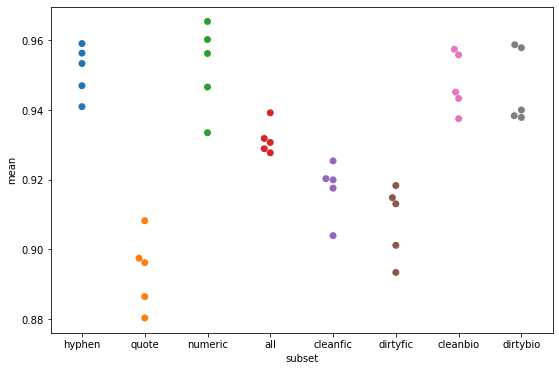

In [108]:
plt.figure(figsize = (9, 6))
sns.swarmplot(data = df, x = 'subset', y = 'mean', size = 7)

In [91]:
np.mean(numericprobs)

0.93801425390625

In [92]:
np.mean(allprobs)

0.9278837541778076

In [ ]:
for aseries in [allficcleanp]

### Assess results

Are the books roughly in the same order no matter whether we use dirty or clean texts?

In [65]:
from scipy.stats import pearsonr, spearmanr

In [66]:
keylist = list(gbclean.keys())

cleanprobs = []
dirtyprobs = []

for key in keylist:
    cleanprobs.append(np.mean(gbclean[key]))
    dirtyprobs.append(np.mean(gbdirty[key]))

print('Pearson: ', pearsonr(cleanprobs, dirtyprobs))
print('Spearman: ', spearmanr(cleanprobs, dirtyprobs))

Pearson:  (0.9527454884159031, 9.395404391083857e-11)
Spearman:  SpearmanrResult(correlation=0.9744360902255638, pvalue=4.0365222137155066e-13)


**Yes, correlation between the book averages is very high.**

### But what if we compare biography to fiction?

Read in metadata so we can infer genre.

In [53]:
meta = pd.read_csv('sentencemetav1.tsv', sep = '\t')
meta.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed,isbio,passagefails,worderrors
0,inu.30000115426458,"Fielding, Henry",1707-1754,The history of the adventures of Joseph Andrew...,1742,1743.0,NaN,NaN,2,9609,...,NaN,m,n,two volumes,ted,18cgutenbergtrimmed,Trimmed,False,0.028328,0.150914
1,mdp.39015014138518,"Hawkins, John",1719-1789,"The Life of Samuel Johnson, LLD",1787,1787.0,London: J Buckland,NaN,NaN,HawkJLSbio,...,NaN,m,NaN,NaN,NaN,NaN,NaN,True,0.059192,0.036669
2,uc2.ark+=13960=t7pn8z31x,"Hawthorne, Nathaniel",1804-1864.,Little masterpieces,1864,1897.0,New York;Doubleday & McClure,"Hawthorne, Nathaniel | Little Masterpieces",NaN,39716,...,NaN,m,NaN,NaN,peizhen,NaN,NaN,False,0.025850,0.015333
3,uc2.ark+=13960=t78s4tc10,"Kavanagh, Julia",1824-1877.,Rachel Gray,1856,1856.0,New York;Appleton;1856.,"Kavanagh, Julia | Rachel Gray",NaN,36160,...,NaN,f,NaN,NaN,peizhen,NaN,NaN,False,0.074475,0.026068
4,coo1.ark+=13960=t2t447q6w,"Boldrewood, Rolf",1826-1915.,Nevermore,1892,1892.0,"London and New York, Macmillan and co., 1892.","Boldrewood, Rolf | Nevermore",NaN,34240,...,NaN,m,NaN,NaN,ted,NaN,NaN,False,0.098180,0.009523


In [54]:
meta.columns

Index(['docid', 'author', 'authordate', 'title', 'latestcomp', 'hathidate',
       'imprint', 'gutenstring', 'enumcron', 'gbindex', 'nonficprob',
       'juvenileprob', 'LOCgenres', 'LOCsubjects', 'contents', 'instances',
       'genre', 'audience', 'authgender', 'multiplehtids', 'comments', 'coder',
       'Folder', 'Trimmed', 'isbio', 'passagefails', 'worderrors'],
      dtype='object')

Let's reorganize the probabilities-by-volume into master lists for fiction and biography, and then do t tests on the paired lists for both clean and dirty data.

In [68]:
from scipy.stats import ttest_ind
keylist = list(gbclean.keys())
ficcleanprobs = []
biocleanprobs = []
ficdirtyprobs = []
biodirtyprobs = []

for key in keylist:
    genre = meta.loc[meta.gbindex == key, 'genre'].values[0]
    if 'fic' in genre:
        ficcleanprobs.extend(gbclean[key])
        ficdirtyprobs.extend(gbdirty[key])
    elif 'bio' in genre:
        biocleanprobs.extend(gbclean[key])
        biodirtyprobs.extend(gbdirty[key])
    else:
        print(genre)
        
print('clean: ', ttest_ind(ficcleanprobs, biocleanprobs))
print('dirty: ', ttest_ind(ficdirtyprobs, biodirtyprobs))
        

clean:  Ttest_indResult(statistic=-1.2552356633919197, pvalue=0.209466695373298)
dirty:  Ttest_indResult(statistic=-2.5526956935666116, pvalue=0.010726182227341407)


**Wow, that could be a distortion.** We get a significant difference between biography and fiction, but only using the dirty data!

What are the actual means we're talking about here?

In [63]:
print(np.mean(ficcleanprobs), np.mean(biocleanprobs))
print(np.mean(ficdirtyprobs), np.mean(biodirtyprobs))

0.937915840296496 0.9471690701195219
0.9243410377358491 0.9441725521912351


One working hypothesis here is that quotation marks tend to reduce perceived probability of transition. They're more common in fiction to start with, and *misplaced* quotation marks seem to be especially fatal. So there could be something about next-sentence prediction, and about the bio/fic boundary, that makes bad OCR esp fatal here.

It's also notable that dirty probabilities are generally (and significantly) lower than clean.